In [18]:
# MSSG, based on JEM and LCA code
# NB version, Start: 12/2015

%pylab inline

### Generic imports
import lmfit
import ipdb
import sys
import random
#import triangle
from argparse import ArgumentParser
#import matplotlib.pyplot as plt
#import numpy as np

### Specific imports
import galsim
import mssg_deblend
# import mssg_drawLibrary
# from mssg_makeplot import *
# from mssg_create_blend import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [19]:

###################################################### Function to create the blended img

def create_blend(peak_a, peak_b, flux_bTOa = 1, size_bTOa = 1, e1a = 0, e1b = 0 , e2a = 0, e2b = 0, imgsize = 0, 
                 pixelscale = 0, 
                 mrkrsize = 10, psetval = 1, galtype = 'G', verbose = 0, noise = 0):

    if (verbose > 0):
        print "--------------> In local createblend"
    # Global vars
    randnum=galsim.BaseDeviate(1) # Random num seed -- when set to zero, uses machine time

    #### Level to do printing at (setting it lower will plot more stuff)
    presetval = psetval
    plotflag =  0  # The default, to plot the minimum, Higher = plot more diagnostic plots
    
    # Create gaussian gal objs, sheared in various directions
    hlr_a = 1.0
    hlr_b = hlr_a * size_bTOa

    flux_a = 1e7
    flux_b = flux_a * flux_bTOa
    
    # Make the Gaussian gals
    gal1 = galsim.Gaussian(half_light_radius= hlr_a , flux= flux_a).shear(g1=e1a, g2= e2a).shift(peak_a)
    gal2 = galsim.Gaussian(half_light_radius= hlr_b , flux= flux_b ).shear(g1=e1b, g2= e2b).shift(peak_b)
    
    ################################# Make actual profile
    deVauc_ix = 4 # deVauc bulge
    expl_ix = 1   # expl bulge
    
    if (galtype == 'Se'):
    # Create primary galaxy 
        print "********* Making Sersic profile expl gals"
        gal1 = galsim.Sersic(n=expl_ix, flux=flux_a,half_light_radius= hlr_a).shift(peak_a)
        gal2 = galsim.Sersic(n=expl_ix, flux=flux_b,half_light_radius= hlr_b).shift(peak_b)
    else:
        if (galtype == 'Sd'):
    # Create primary galaxy 
            print "********* Making Sersic profile deVauc gals"
            gal1 = galsim.Sersic(n=deVauc_ix, flux=flux_a,half_light_radius= hlr_a).shift(peak_a)
            gal2 = galsim.Sersic(n=deVauc_ix, flux=flux_b,half_light_radius= hlr_b).shift(peak_b)

        else:
            print "*********** Making Gaussian gals"
 #           gal1 = galsim.Sersic(n= 0.5 , flux=flux_a,half_light_radius= hlr_a).shear(g1=e1a, g2= e2a).shift(peak_a)
  #          gal2 = galsim.Sersic(n= 0.5 , flux=flux_b,half_light_radius= hlr_b).shear(g1=e1b, g2= e2b).shift(peak_b)
    

    # Add psf 
    psfshr = 0.00
    psf = galsim.Moffat(beta=3, fwhm=0.85).shear(e1 = psfshr,  e2 = -psfshr)

    convgal1 = galsim.Convolve([gal1,psf])
    convgal2 = galsim.Convolve([gal2,psf])
    
    ##################### Now make imgs
    ######### Figure out the center
    imgcent = imgsize/2

    if (verbose > 0):
        print "peak_a[0] = ", peak_a[0]
        print 'imgcent = ', imgcent
    acent = (imgcent+peak_a[0]/pixelscale, imgcent+peak_a[1]/pixelscale)
    bcent = (imgcent+peak_b[0]/pixelscale, imgcent+peak_b[1]/pixelscale)

    # Img1
    proto_image = galsim.ImageD(imgsize, imgsize, scale = pixelscale)
#    image1 = convgal1.drawImage(image=proto_image, method='phot', rng=randnum)  # Photon shooting
    image1 = convgal1.drawImage(image=proto_image)

    # Define some params
    sky_level = 1.e6
    pixel_scale = 0.2
    sky_level_pixel = sky_level * pixel_scale**2  # This is the num of photons per pixel?

#    random_seed = np.random.randint(2**62) 
 #   udRandomSeed = galsim.UniformDeviate(random_seed)
  #  noise = galsim.GaussianNoise(udRandomSeed, sky_level=sky_level_pixel)
    noise = noise
    image1.addNoise(galsim.GaussianNoise(sigma=noise))
    # addNoiseSNR(noise, gal_signal_to_noise)
 

#    print image1.array[np.where(image1.array < 0)] 
#    image1.array[np.where(image1.array < 0)] = 0.
    
       # Img2
    proto_image = galsim.ImageD(imgsize, imgsize, scale = pixelscale)
#    image2 = convgal2.drawImage(image=proto_image, method='phot', rng=randnum)   # Photon shooting
    image2 = convgal2.drawImage(image=proto_image)
#    image2.array[np.where(image2.array < 0)] = 0.    


    ############## Add them into one image
    imagesum =  image1+image2    

     
    ########### Optional: If we want to show plots on screen here
    if plotflag > presetval:           
        if (verbose > 0):
             print '************** About to show plots with flux a = ', flux_a , ', flux_b = ', flux_b
        pltname =  " FIRST PLOT:  Img obj a"
        pltcontent =   image1.array 
        plt.title(" FIRST PLOT:  Img obj a")
        plt.imshow( image1.array , origin='lower', interpolation='none' );    
        plt.colorbar()
        plt.plot( acent[0], acent[1], color='g', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
        plt.show()
        if (verbose > 0):
            print " >>>>>> Plotting img obj a"
            print " image1.array.sum() " , image1.array.sum()
        center = (peak_a, peak_b)

    if plotflag > presetval: 
        if (verbose > 0):
            print " >>>>>> Plotting img obj b"
        plt.title(" Img obj b")
        plt.imshow( image2.array , origin='lower',  interpolation='none' );    
        plt.colorbar()
        plt.plot(bcent[0], bcent[1],  color='y', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
        plt.show()
    
    # Summed img
    if plotflag > presetval:
        plt.title(" Img obj a + b")
        if (verbose > 0):
            print " >>>>>> Plotting imgsum"
        plt.plot( acent[0], acent[1], color='g', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
        plt.plot(bcent[0], bcent[1],  color='y', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
        
        plt.imshow( imagesum.array , origin='lower',  interpolation='none' );    
        plt.colorbar()
        plt.show()
    

    return imagesum, [image1, image2]


#################################################### Function to draw gal figs
def makeplot(pltname, pltcontent,  centre=(0,0) , colorbarlimit = 0, location = 'lower', mrkrsize = 10 ,qrtr = 0.25, 
             verbose = 0, scaling = 'nondk'):

    # The dk scaling is to go symmetrically in the color bar from minimum negative to maximum positive identical value
    # nondk scaling will let Python pick its own colorscale
    # Color bar limit will make Color scale go out of 100%
    # mrkrsize is for marking the centers of the objects
    # centre is to set the location of the central of the object

          if (verbose > 1):
            print " In local makeplot"
            
          plt.title(pltname)
          if (verbose > 0):
            print " >>>>>> Plotting ", pltname          
          dummyarr = np.array([1, 2, 3])
          if type(pltcontent) != type(dummyarr):
              print pltcontent, " is not a numpy array, will convert"
              pltcontent = pltcontent.array
          
         
   
          if (scaling == 'dk'):
              vmin,vmax = np.percentile(pltcontent,[1,99])
              vmax = max(abs(vmin),abs(vmax))
              vmin = -vmax
              pltimg = plt.imshow( pltcontent , origin=location, interpolation='none', vmin = vmin, vmax=vmax );
          else:
            pltimg = plt.imshow( pltcontent , origin=location, interpolation='none' );
 

#          pltimg = plt.imshow( pltcontent , origin=location, interpolation='none', vmin = vmin, vmax=vmax );

          # To correctly set the values of X and Y axes 
          ysize,xsize = pltcontent.shape
          plt.xlim(qrtr*xsize,(1-qrtr)*xsize)
          plt.ylim(qrtr*ysize,(1-qrtr)*ysize)
          
          if colorbarlimit==1:
                    pltimg.set_clim(-1,1)
          plt.colorbar()
        
          # Plotting the centers of each profile with a little circle
          if (centre[0][0] !=0 and centre[1][0] !=0):
                    if (verbose > 0):
                        print "---------------> Plotting centers"
                    plt.plot(centre[0][0], centre[0][1],  color='g', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
                    plt.plot(centre[1][0], centre[1][1],  color='y', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
          else:
            if (verbose > 0):
                print "---------------> NOT Plotting centers"
                
          plt.show()
    # plt.annotate
    

#################################################### Function to make gal fig objects, and pass them back
def passplot(pltname, pltcontent, inax, centre=(0,0) , colorbarlimit = 0, location = 'lower', mrkrsize = 10 ,
             qrtr = 0.25, scaling ="dk", verbose = 0):
        
          # Quite similar structure to makeplot, so see above for more comments
          # The difference is that this will make the plots in an array and without color bars

          if (verbose > 0):
                print "In local pass plot"
          inax.set_title(pltname)
          if (verbose > 0):
                print " >>>>>> Plotting ", pltname          
          dummyarr = np.array([1, 2, 3])
          if type(pltcontent) != type(dummyarr):
              if (verbose > 0):
                  print pltcontent, " is not a numpy array, will convert"
              pltcontent = pltcontent.array
          
          if (scaling == 'dk'):
              vmin,vmax = np.percentile(pltcontent,[1,99])
              vmax = max(abs(vmin),abs(vmax))
              vmin = -vmax
              pltimg = inax.imshow( pltcontent , origin=location, interpolation='none', vmin = vmin, vmax=vmax );
          else:
              pltimg = inax.imshow( pltcontent , origin=location, interpolation='none' );
          
          ysize,xsize = pltcontent.shape
        
          inax.set_xlim(qrtr*xsize,(1-qrtr)*xsize)
          inax.set_ylim(qrtr*ysize,(1-qrtr)*ysize)
          '''
          if colorbarlimit==1:
                    pltimg.set_clim(-1,1)
          inax.colorbar()
          '''
          if (centre[0][0] !=0 and centre[1][0] !=0):
                    inax.plot(centre[0][0], centre[0][1],  color='g', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
                    inax.plot(centre[1][0], centre[1][1],  color='y', marker = 'o', markersize=mrkrsize, markeredgewidth=1)
                 
    # plt.annotate
    

In [58]:







###################################################### Initze  &  Set sep

###################################### Main flags

# Parse command line args
parser = ArgumentParser()
parser.add_argument("--outfile", default="deblendsOutput/deblendingTests", help="output text filename")
parser.add_argument("--e1a", default=0, type=float, help="e1a in")
parser.add_argument("--e2a", default=0, type=float, help="e2a in")
parser.add_argument("--e1b", default=0, type=float, help="e1b in")
parser.add_argument("--e2b", default=0, type=float, help="e2b in")
parser.add_argument("--plotflag", default=0, type=int, help="Set to 1 to make plots")
parser.add_argument("--centers", default=1, type=int, help="Set to 1 to use exact centers, 2 to use centers from simfit")

args = parser.parse_args("")  # In ipynb, this makes the args be all the default args as above

########## Get ellips from "cmd line" here in ipynb
e1ain = args.e1a ; e2ain = args.e2a
e1bin = args.e1b ; e2bin = args.e2b

plotflag = args.plotflag
centers = args.centers

##################################### Initze



#### Level to do plotting at (setting it lower will plot more stuff)
presetval = 1

#### Whether to plot (setting it higher will plot more stuff)
plotflag = 2

## Color scheme
plt.rcParams['image.cmap'] = 'seismic'

## Print verbosity
verbose = 2  # Zero is less, 1 is more, 2 is all

########### Img params
imsize = 101
pixel_scale = 0.2

########### Amount of noise to put in
noiselevel = 2e4

########################## Set the peak locations

# ************************************************************************ 4 arcsec sep
# origpeak_a = (-2,0);   origpeak_b = (2,0)    
# ************************************************************************ 2 arcsec sep
xcent = 1.5
origpeak_a = (-xcent,0);   origpeak_b = (xcent,0)    

if centers == 1:
    curpeak_a = origpeak_a ;   curpeak_b = origpeak_b


################################################################# Assign to actual peak variable
peak_a =  np.array(curpeak_a) ; peak_b =  np.array(curpeak_b) 


########  Convert peaks_pix to pixels
peaks_pix = [[p1/0.2 for p1 in peak_a],  # Div by 0.2 to convert back to pixels
             [p2/0.2 for p2 in peak_b]]

if (verbose > 0):
    print " \n\n\n  ************************* Using these centers: "   
    print " Arcsec: peaks_A = " , peak_a
    print " Arcsec: peaks_B = " , peak_b
    print " Pixels: peaks_pix = " ,  peaks_pix 

### Now do the actual deblending
templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, 
                                                               interpolate=False, force_interpolate = False)

##### These numbers are needed to plot points at center of imgs
imgsize = imsize
pixelscale = pixel_scale 
imgcent = imgsize/2
acent = (imgcent+peak_a[0]/pixelscale, imgcent+peak_a[1]/pixelscale)
bcent = (imgcent+peak_b[0]/pixelscale, imgcent+peak_b[1]/pixelscale)

### The center var that will be plotted on the figs
center= (acent,bcent)

if (verbose > 0):
    print "center[0][0] = ",center[0][0]
    print "center[0][1] = ",center[0][1]
    print "center[1][0] = ",center[1][0]
    print "center[1][1] = ",center[1][1] 

print "-------> plotflag = ", plotflag
print "-------> presetval = ", presetval


if (verbose > 0):
    print " ******************************* Peaks are at: "
    print " In Arcsec: peaks_A = " , peak_a
    print " In Arcsec: peaks_B = " , peak_b

    print "\n Pixels: peaks in pixels = " ,  peaks_pix


print " \n\n\n ------------------------------------------------> Initzn Done"
    

 


  ************************* Using these centers: 
 Arcsec: peaks_A =  [-1.5  0. ]
 Arcsec: peaks_B =  [ 1.5  0. ]
 Pixels: peaks_pix =  [[-7.5, 0.0], [7.5, 0.0]]
center[0][0] =  42.5
center[0][1] =  50.0
center[1][0] =  57.5
center[1][1] =  50.0
-------> plotflag =  2
-------> presetval =  1
 ******************************* Peaks are at: 
 In Arcsec: peaks_A =  [-1.5  0. ]
 In Arcsec: peaks_B =  [ 1.5  0. ]

 Pixels: peaks in pixels =  [[-7.5, 0.0], [7.5, 0.0]]
 


 ------------------------------------------------> Initzn Done


*********** Making Gaussian gals
(max(blend.array) =  115284.313268


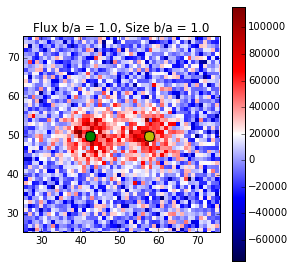

*********** Making Gaussian gals
(max(blend.array) =  102908.113696


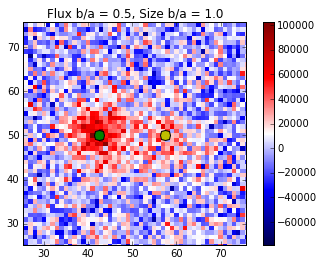

*********** Making Gaussian gals
(max(blend.array) =  99387.8926428


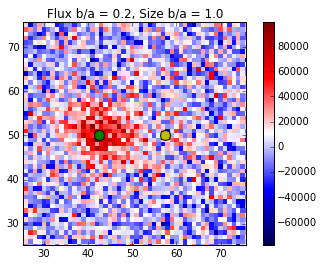

*********** Making Gaussian gals
(max(blend.array) =  103396.474732


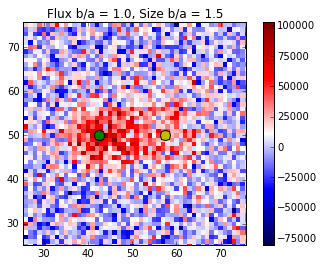

*********** Making Gaussian gals
(max(blend.array) =  110697.857711


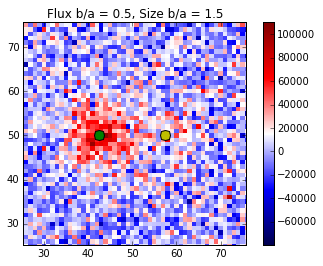

*********** Making Gaussian gals
(max(blend.array) =  101332.929296


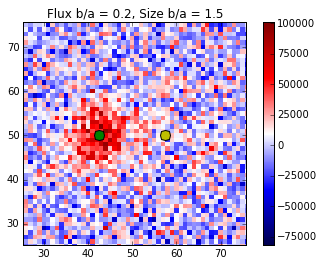

In [59]:


##################  Plot the orig figs ---- using makeplot  (i.e. with colorbars)

fig = plt.figure(figsize = (15,10))
localgaltype = 'G'

#### Input vals
e1ain = 0; e2ain = 0
e1bin = 0; e2bin = 0

for size_bTOa in [1.0, 1.5]:    
  for flux_bTOa in [1.0, 0.5,0.2]:
    blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa , e1a = e1ain,                                 
                               galtype = localgaltype , e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, 
                               pixelscale = pixel_scale, mrkrsize = 10, psetval = 0, noise = noiselevel)
    pltcontent = blend.array
    ax = fig.add_subplot(231)
    pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
#    center = (peak_a, peak_b)
    print "(max(blend.array) = ", np.max(blend.array)
    if (plotflag > -1):
        makeplot(pltname, pltcontent,  centre=center, scaling = 'nondk')
    




------------------> Peakval =  1
--------------> In local createblend
*********** Making Gaussian gals
peak_a[0] =  -1.5
imgcent =  50
 In local makeplot
 >>>>>> Plotting  Flux b/a = 1.0, Size b/a = 1.0
---------------> Plotting centers


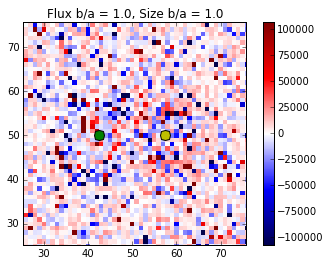

--------------> In local createblend
*********** Making Gaussian gals
peak_a[0] =  -1.5
imgcent =  50
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1.0
---------------> Plotting centers


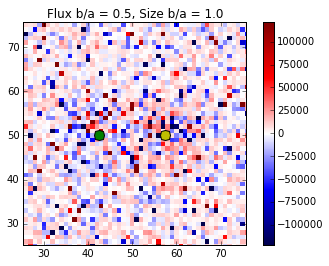

--------------> In local createblend
*********** Making Gaussian gals
peak_a[0] =  -1.5
imgcent =  50
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1.0
---------------> Plotting centers


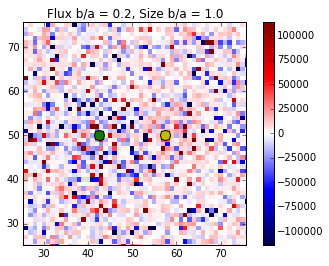

--------------> In local createblend
*********** Making Gaussian gals
peak_a[0] =  -1.5
imgcent =  50
 In local makeplot
 >>>>>> Plotting  Flux b/a = 1.0, Size b/a = 1.5
---------------> Plotting centers


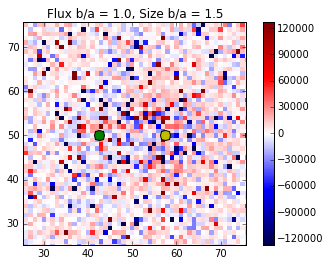

--------------> In local createblend
*********** Making Gaussian gals
peak_a[0] =  -1.5
imgcent =  50
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1.5
---------------> Plotting centers


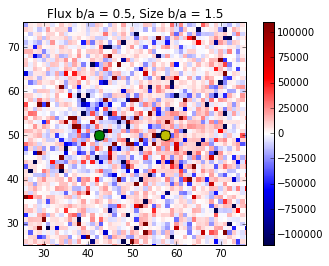

--------------> In local createblend
*********** Making Gaussian gals
peak_a[0] =  -1.5
imgcent =  50
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1.5
---------------> Plotting centers


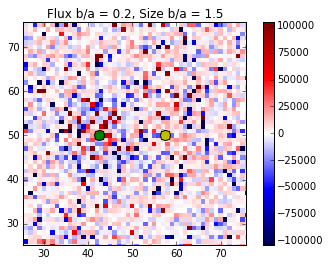

In [60]:
############################################### Plot the resid figs -- with makeplot

localgaltype = 'G'
peakval =1 
e1ain = 0
e2ain = 0

e1bin = 0
e2bin = 0

if (verbose > 0):
    print "------------------> Peakval = ", peakval

flux_bTOa = 1
size_bTOa = 1

for size_bTOa in [1.0, 1.5]:    
  for flux_bTOa in [1.0, 0.5,0.2]:
    
    blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa , e1a = e1ain,  e2a = e2ain, 
                               e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10,
                               galtype= localgaltype, verbose = verbose, noise = noiselevel)
    templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
    pltcontent = (children[0] - unblends[0].array)/  peakval
    pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
    if (plotflag > -1):
        makeplot(pltname, pltcontent,  centre=center,verbose = verbose, scaling='dk')



*********** Making Gaussian gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 1.0, Size b/a = 1.0
---------------> Plotting centers


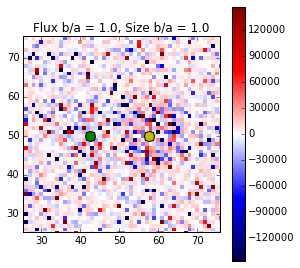

********* Making Sersic profile expl gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 1.0, Size b/a = 1.0
---------------> Plotting centers


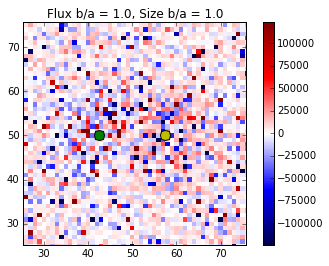

********* Making Sersic profile deVauc gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 1.0, Size b/a = 1.0
---------------> Plotting centers


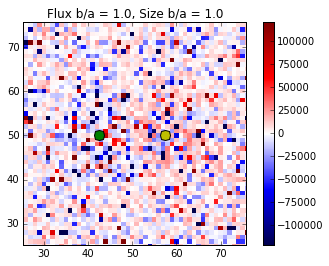

*********** Making Gaussian gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1.0
---------------> Plotting centers


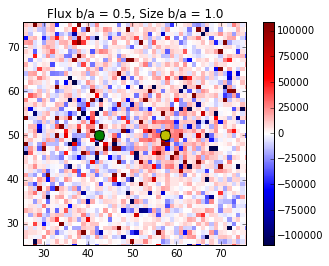

********* Making Sersic profile expl gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1.0
---------------> Plotting centers


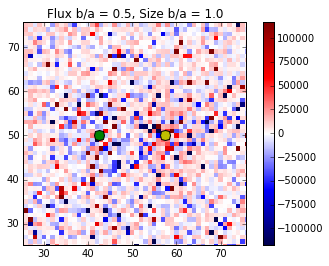

********* Making Sersic profile deVauc gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1.0
---------------> Plotting centers


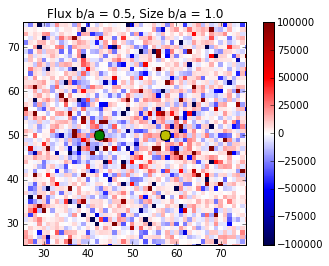

*********** Making Gaussian gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1.0
---------------> Plotting centers


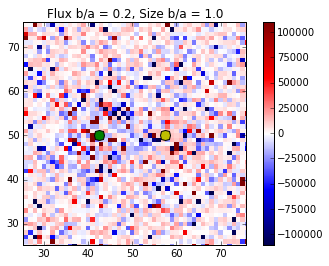

********* Making Sersic profile expl gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1.0
---------------> Plotting centers


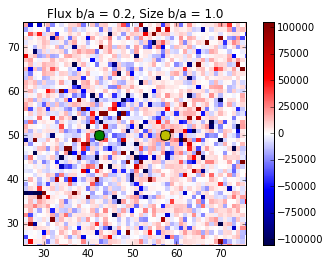

********* Making Sersic profile deVauc gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1.0
---------------> Plotting centers


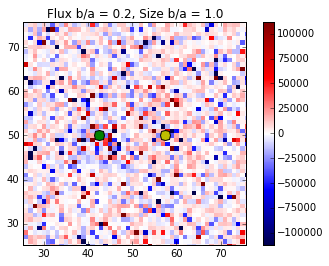

*********** Making Gaussian gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 1.0, Size b/a = 1.5
---------------> Plotting centers


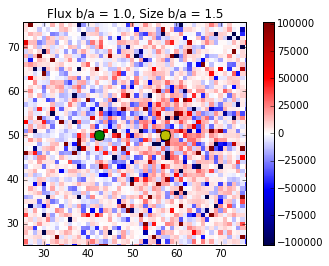

********* Making Sersic profile expl gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 1.0, Size b/a = 1.5
---------------> Plotting centers


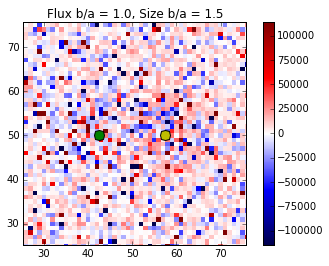

********* Making Sersic profile deVauc gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 1.0, Size b/a = 1.5
---------------> Plotting centers


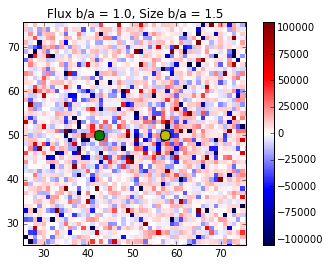

*********** Making Gaussian gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1.5
---------------> Plotting centers


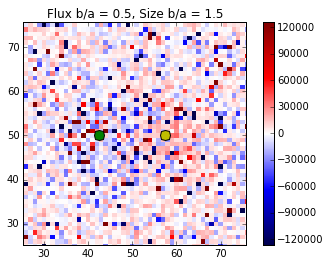

********* Making Sersic profile expl gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1.5
---------------> Plotting centers


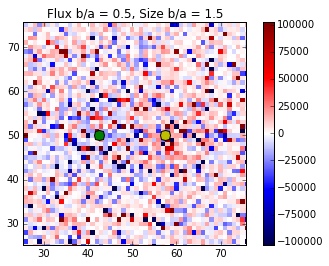

********* Making Sersic profile deVauc gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.5, Size b/a = 1.5
---------------> Plotting centers


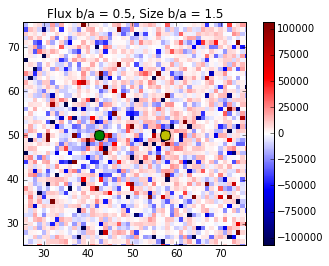

*********** Making Gaussian gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1.5
---------------> Plotting centers


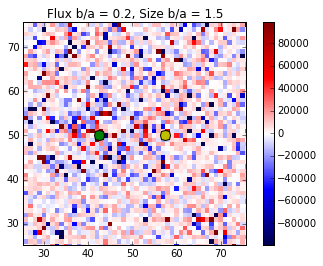

********* Making Sersic profile expl gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1.5
---------------> Plotting centers


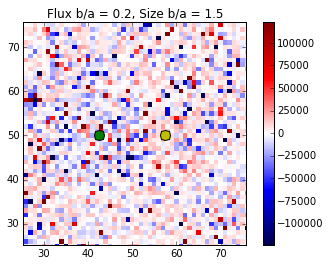

********* Making Sersic profile deVauc gals
 In local makeplot
 >>>>>> Plotting  Flux b/a = 0.2, Size b/a = 1.5
---------------> Plotting centers


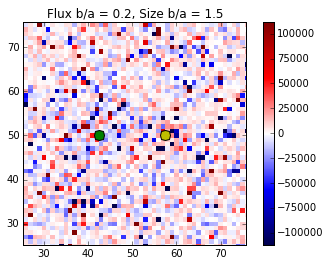

In [61]:
############################################### Plot the resid figs -- compare G, Se, Sd

fig = plt.figure(figsize = (15,10))

##################  Loop over all possibilities, plot the resids

plotflag = 1

for size_bTOa in [1.0, 1.5]:    
  for flux_bTOa in [1.0, 0.5,0.2]:

    for galtype in ['G', 'Se', 'Sd']:
        blend, unblends = create_blend(peak_a, peak_b, galtype = galtype , flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa , 
                               e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, 
                                       pixelscale = pixel_scale, mrkrsize = 10, noise=noiselevel)
        templates, template_fractions, children = mssg_deblend.deblend(blend.array, peaks_pix, interpolate=False, force_interpolate = False)
        pltcontent = (children[0] - unblends[0].array)/  peakval ; ax = fig.add_subplot(231) ; pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
        if (plotflag > -1):
           makeplot(pltname, pltcontent, centre=center, verbose = verbose, scaling = 'dk')


--------------> In local createblend
*********** Making Gaussian gals
peak_a[0] =  -1.5
imgcent =  50
Plotting resid


/Users/m/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


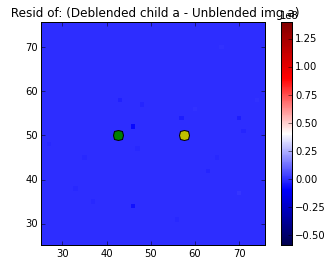

''

In [62]:
################## Old test code: Create the blended obj  

blend, unblends = create_blend(peak_a, peak_b, e1a = e1ain,  e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, 
                               pixelscale = pixel_scale, mrkrsize = 10, 
                               psetval = 1, galtype='G', verbose = verbose)
    

if plotflag > presetval:
    plt.title(" Sanity check: Img blended obj - (a+b) ")
    if (verbose > 0):
        print " >>>>>> Plotting blend.array - (unblends[0].array + unblends[1].array)  "
    plt.imshow( blend.array - (unblends[0].array + unblends[1].array) , origin='lower',  interpolation='none' );    
    plt.colorbar()
    plt.show()


########## Plot template
if plotflag > presetval:
    pltname = " Template obj a "
    pltcontent = template_fractions[0] 
   
    if (plotflag > -1):
        makeplot(pltname, pltcontent, centre=center)

######### Plot children
    ### Obj a
  
    peakval = unblends[0].array[acent[0], acent[1]]
    if (verbose > 0):
        print " peakval = ", peakval
 
if plotflag > presetval-2:
    if (verbose > 0):
        print "Plotting resid"
    pltname = " Resid of: (Deblended child a - Unblended img a) ";        # If we want to Nze: / peak val of a 
    peakval = unblends[0].array[acent[0], acent[1]]
    pltcontent = (children[0] - unblends[0].array)

    if (plotflag > -1):
        makeplot(pltname, pltcontent, centre=center)
;

*********** Making Gaussian gals
*********** Making Gaussian gals
*********** Making Gaussian gals
*********** Making Gaussian gals
*********** Making Gaussian gals
*********** Making Gaussian gals


'    \nax = fig.add_subplot(231)\npltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)\npassplot(pltname, pltcontent, ax, centre=center, scaling = \'nondk\')\n\n\nflux_bTOa = 0.5\nsize_bTOa = 1\nblend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa, e1a = e1ain,  \n                               galtype = localgaltype , e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)\npltcontent = blend.array\nax = fig.add_subplot(232)\npltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)\npassplot(pltname, pltcontent, ax, centre=center , scaling = \'nondk\')\n'

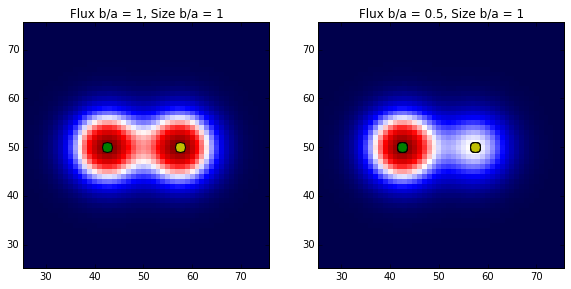

In [63]:

##################  Not currently using this, and it's not fully written out, either (1/17/2016)


######## Plot the orig figs ---- passplot  -- using arrays

fig = plt.figure(figsize = (15,10))

#### Input vals
localgaltype = 'G'

e1ain = 0
e2ain = 0

e1bin = 0
e2bin = 0

flux_bTOa = 1
size_bTOa = 1

for wplot in range(1,7):    

    if (wplot == 1): 
        flux_bTOa = 1 ; 
        size_bTOa = 1 ; 
        ax = fig.add_subplot(231)
    if (wplot == 2): 
        flux_bTOa = 0.5 ; 
        size_bTOa = 1 ; 
        ax = fig.add_subplot(232)

    blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa , e1a = e1ain,  
                                   galtype = localgaltype, e2a = e2ain, e1b = e1bin ,e2b = e2bin, 
                                   imgsize=imsize, pixelscale = pixel_scale, mrkrsize = 10, psetval = 2)
    pltcontent = blend.array
    pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
    passplot(pltname, pltcontent, ax, centre=center, scaling = 'nondk')

'''    
ax = fig.add_subplot(231)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
passplot(pltname, pltcontent, ax, centre=center, scaling = 'nondk')


flux_bTOa = 0.5
size_bTOa = 1
blend, unblends = create_blend(peak_a, peak_b, flux_bTOa =  flux_bTOa , size_bTOa = size_bTOa, e1a = e1ain,  
                               galtype = localgaltype , e2a = e2ain, e1b = e1bin ,e2b = e2bin, imgsize= imsize, pixelscale = pixel_scale, mrkrsize = 10)
pltcontent = blend.array
ax = fig.add_subplot(232)
pltname = "Flux b/a = "+str(flux_bTOa) + ", Size b/a = "+str(size_bTOa)
passplot(pltname, pltcontent, ax, centre=center , scaling = 'nondk')
'''

1
2
3
4
5
6
